# Unsupervised analytics of kagglers in 2018

On this small notebook, I going to attempt to analyse the kaggle 2018 survey data without presuppositions. In order to do this I will attempt to create my own "dummy labels" through k-means clustering, then apply some suppervised learning algorithms. I refer to these labels as "dummy labels" because in this case, the classification capabilities of the models will not be as relevant as the statistical structures found after training them in the data. The labels exists solely as a token ofr the model to latch on to during training. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix




## Preprocessing the data

Let's import the data set corresponding to multiple choice questions:

In [2]:
multiplec = pd.read_csv('multipleChoiceResponses.csv')


/Users/rasputin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mkeys=multiplec.keys()
#excludes the columns corresponding to text explaining
multiplec=multiplec.drop([ mkeys[2], mkeys[8], mkeys[10],mkeys[23], mkeys[24], mkeys[25],mkeys[26], mkeys[44], mkeys[56], mkeys[64], mkeys[83], mkeys[85], 
                       mkeys[87], mkeys[107], mkeys[109], mkeys[123],mkeys[125], mkeys[150], 
                          mkeys[194], mkeys[223], mkeys[249],mkeys[262], mkeys[264],mkeys[276],
                      mkeys[304],mkeys[306], mkeys[329], mkeys[341], mkeys[371], mkeys[385], mkeys[394],mkeys[283]],axis=1)
multiplec.keys()

Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q7', 'Q8', 'Q9',
       ...
       'Q49_Part_11', 'Q49_Part_12', 'Q50_Part_1', 'Q50_Part_2', 'Q50_Part_3',
       'Q50_Part_4', 'Q50_Part_5', 'Q50_Part_6', 'Q50_Part_7', 'Q50_Part_8'],
      dtype='object', length=363)

In [4]:
multi2=multiplec.iloc[1:,:]


Now, because many of the features are cathegorical, it is necesary to encode them before sending them to an algorithm. One-hot enconding is a feasible choice, since it does not create unwanted order in the data. It is also important to scale the column "Time from start to finish (seconds)", to match the 0-1 interval of the rest of the data. To deal with missing values, they will be replaced by -1.

In [5]:
#since the first column is actually composed of integers, we do not include it in the encoding
obj_df = multi2.select_dtypes(include=['object']).copy()
obj_df = obj_df.drop(mkeys[0],axis=1)

In [6]:
#One-Hot encoding using pandas
obj_df=pd.get_dummies(obj_df)
np.shape(obj_df)

(23859, 4404)

In [7]:
#scaling the time column
x = multi2.iloc[:,0].values.astype(float) 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
df_scaled = pd.DataFrame(x_scaled,columns=['Time from Start to Finish (seconds)'])
#adjusting the indices
df_scaled.index+=1

In [8]:
#Creating our encoded data frame
encoded_data = pd.concat([df_scaled,obj_df,multi2.select_dtypes(exclude=['object']).copy()],axis=1)
print(np.shape(encoded_data))
encoded_data.head()

(23859, 4405)


,Time from Start to Finish (seconds),Q1_Female,Q1_Male,Q1_Prefer not to say,Q1_Prefer to self-describe,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,...,Q49_Part_11_None/I do not make my work easy for others to reproduce,Q49_Part_12_Other,Q50_Part_1_Too expensive,Q50_Part_2_Too time-consuming,Q50_Part_3_Requires too much technical knowledge,Q50_Part_4_Afraid that others will use my work without giving proper credit,Q50_Part_5_Not enough incentives to share my work,Q50_Part_6_I had never considered making my work easier for others to reproduce,Q50_Part_7_None of these reasons apply to me,Q50_Part_8_Other
1,0.000784,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000472,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000793,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0.000683,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
5,0.000807,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [9]:
#changes nan values two -1
encoded_data = encoded_data.fillna(value=-1)
enc_keys=encoded_data.keys()

## Unsupervised Learning

One-hot encoding has created a data matrix with 4405 columns. In order to reduce computing time in k-menas, PCA is used to find a low dimentional representation of the data.

First eigen-vector var fraction: 0.4304887617002818  second var 0.10419073483807538


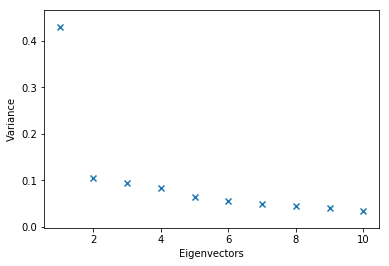

In [10]:
#pca to reduce dimentionality
pca = PCA(n_components=10)
pca.fit(encoded_data)
var=pca.explained_variance_
n_com=np.linspace(1,10,10)
plt.scatter(n_com,var/np.sum(var),marker='x')
plt.xlabel('Eigenvectors')
plt.ylabel('Variance')
print('First eigen-vector var fraction:', var[0]/np.sum(var), ' second var', var[1]/np.sum(var))
data_proj= pca.transform(encoded_data)

Now, using the projected data set data_proj we are going to attempt and create some clusters. Using 
the elbow method, we can determine that 2 clusters are a good starting point. These two clusters are then plotted, with their respective centroids. 

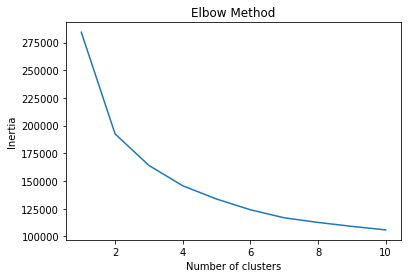

In [11]:
#mean inertia for the clusters formed
inert = []
#elbow method
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=500,n_init=10)
    kmeans.fit(data_proj)
    inert.append(kmeans.inertia_)
plt.plot(range(1,11),inert)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Text(0.5,1,'Clusters')

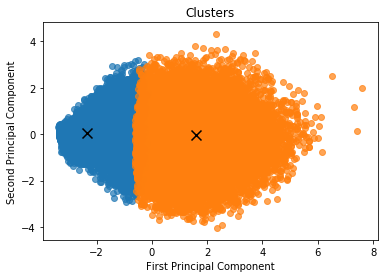

In [12]:
#looking at the 2 cluster case
n_c=2
kmeans_pca = KMeans(n_clusters=n_c,init='k-means++',max_iter=500,n_init=10,random_state=0) 
clus_index = kmeans_pca.fit_predict(data_proj) #saves the cluster labels in the positions of each observation

#Scatter plots of the projections over the first two principal components
for i in range(0,n_c):
    plt.scatter(np.asarray(data_proj)[clus_index == i, 0], np.asarray(data_proj)[clus_index == i,1], alpha=0.7)

plt.scatter(kmeans_pca.cluster_centers_[:,0], kmeans_pca.cluster_centers_[:,1],marker='x',s=100,c='black')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.title('Clusters')


## Cluster Characterization 

In order to find the relevant features for each cluster, we are going to use a SVM with linear kernel. This model
uses the cluster labels to find the probability of an observation belonging to either class. Since, the kernel is linear, the absolute values of the coeficients can be threated as meassure of feature relevancy.

In [13]:

def get_feat(cl_num,cl_index):
    #Creates a bar plot that show the coefficients associated with the 40 most relevant features that the
    #SVM learns 
    #cl_num: the current cluster label
    #cl_index: an array containing the cluster labels obtained from k-means
    print(1)
    labels=np.zeros(len(cl_index))
#gets positions of the zero cluster members
    ii=np.where(cl_index==cl_num)
    labels[ii]=1
    labels=pd.DataFrame(labels)
    supp = SVC(kernel='linear')
    supp.fit(encoded_data,np.ravel(labels))
    print(2)
    
    coef=(abs(supp.coef_.ravel()))
#The coefficients returned correspond to the features, thus the largest coeficients 
#show the most important features. We can take a look at the first 20 coeficients
    top_coef= np.argsort(coef)[-40:]
    feature_names=encoded_data.keys()[top_coef]
    #creates plots
    plt.figure(figsize=(13,13))
    plt.barh(range(len(feature_names)), coef[top_coef], align='center')
    plt.yticks(range(len(feature_names)), feature_names)
    
    plt.savefig(str(cl_num)+'.pdf')
    
    print('The most relevant feature is: ', encoded_data.keys()[top_coef][-1])
    
    return supp, labels, feature_names


def K_fold(clf,K,X,Y):
    #in case we need to test our model accuracy
    #clf: the trained model
    #K: subdivisions of the training data
    #X: features

    print('ya')
    kf = KFold(n_splits=K)
    lin_model = clf

    #using the confusion matrix
    lin_ERR = []
    l_pre=[]
    l_rec=[]
    print('ya2')

    for train_index, test_index in kf.split(X):
        print(1)
        xk_train, xk_test = X.iloc[train_index], X.iloc[test_index]
        print(2)
        yk_train, yk_test = Y.iloc[train_index], Y.iloc[test_index]
        print(3)
        lin_model.fit(xk_train, yk_train)
        print(4)
        lin_pred=lin_model.predict(xk_test)
        print(5)
        lin_conf=confusion_matrix(yk_test,lin_pred)
        
        #precision recal and f1 values
        l_pre.append(lin_conf[1,1]/(lin_conf[1,1]+lin_conf[0,1]))
        l_rec.append(lin_conf[1,1]/(lin_conf[1,1]+lin_conf[1,0]))


        lin_ERR.append((lin_conf[0,1]+lin_conf[1,0])/np.sum(lin_conf))
        
    return np.mean(lin_ERR), np.mean(l_pre), np.mean(l_rec)

1
2
The most relevant feature is:  Q41_Part_3_Very important


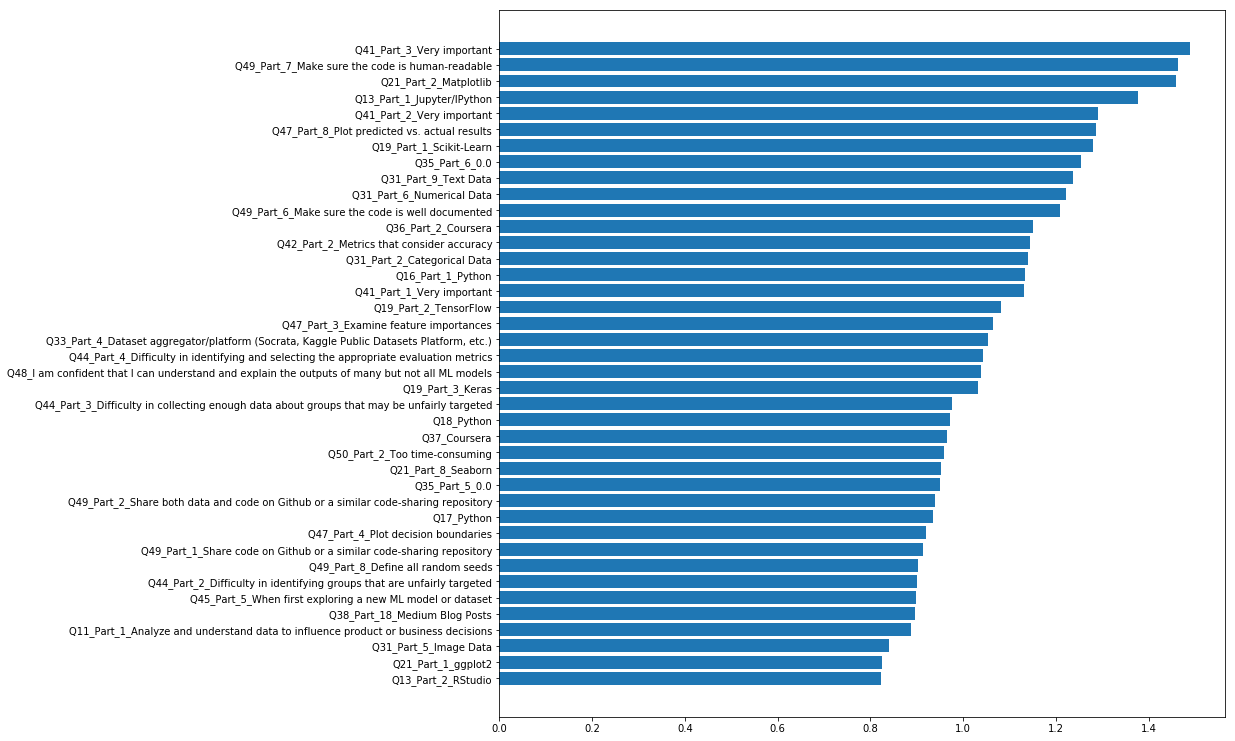

In [14]:
#bar plot for cluster 0
model1, lab1, feat1 =get_feat(0,clus_index)

In [15]:
#error, prec, rec = K_fold(model_used,3, encoded_data, labs)

## Identifying relevant features

The bar plot shown above show the top 40 features that an SVM model learns, in order to classify the data in either 
of the two clusters. The most relevant feature relates to the question "Is reproducibility important in ML". More specifically, the coice "It is very important". Using this top 40 features we are going to go back to the un-encoded set and create a reduced data set for each cluster.


In [17]:
cluster0=encoded_data.iloc[clus_index==0][feat1]
cluster0.head()

,Q13_Part_2_RStudio,Q21_Part_1_ggplot2,Q31_Part_5_Image Data,Q11_Part_1_Analyze and understand data to influence product or business decisions,Q38_Part_18_Medium Blog Posts,Q45_Part_5_When first exploring a new ML model or dataset,Q44_Part_2_Difficulty in identifying groups that are unfairly targeted,Q49_Part_8_Define all random seeds,Q49_Part_1_Share code on Github or a similar code-sharing repository,Q47_Part_4_Plot decision boundaries,...,Q31_Part_9_Text Data,Q35_Part_6_0.0,Q35_Part_6_0.0,Q19_Part_1_Scikit-Learn,Q47_Part_8_Plot predicted vs. actual results,Q41_Part_2_Very important,Q13_Part_1_Jupyter/IPython,Q21_Part_2_Matplotlib,Q49_Part_7_Make sure the code is human-readable,Q41_Part_3_Very important
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,1,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0


In [18]:
#then, we can make a new data ser with these features
cluster1=encoded_data.iloc[clus_index==1][feat1]
cluster1.head()

,Q13_Part_2_RStudio,Q21_Part_1_ggplot2,Q31_Part_5_Image Data,Q11_Part_1_Analyze and understand data to influence product or business decisions,Q38_Part_18_Medium Blog Posts,Q45_Part_5_When first exploring a new ML model or dataset,Q44_Part_2_Difficulty in identifying groups that are unfairly targeted,Q49_Part_8_Define all random seeds,Q49_Part_1_Share code on Github or a similar code-sharing repository,Q47_Part_4_Plot decision boundaries,...,Q31_Part_9_Text Data,Q35_Part_6_0.0,Q35_Part_6_0.0,Q19_Part_1_Scikit-Learn,Q47_Part_8_Plot predicted vs. actual results,Q41_Part_2_Very important,Q13_Part_1_Jupyter/IPython,Q21_Part_2_Matplotlib,Q49_Part_7_Make sure the code is human-readable,Q41_Part_3_Very important
3,0,1,0,1,0,0,0,1,0,0,...,1,0,0,0,1,1,0,1,1,1
4,1,1,0,0,0,0,0,0,0,1,...,1,0,0,1,1,1,1,1,1,1
6,0,0,1,1,1,1,0,0,1,0,...,0,0,0,1,1,1,1,1,1,1
8,0,1,1,0,1,1,0,0,0,0,...,1,0,0,1,0,1,1,1,1,1
10,0,1,0,0,0,1,0,1,0,0,...,1,0,0,1,1,1,1,1,1,0


 A quick value count on the most important feature, could shine some light on the statistical differences between both clusters.

In [200]:
cluster0['Q41_Part_3_Very important'].value_counts()

0    9195
1     489
Name: Q41_Part_3_Very important, dtype: int64

In [201]:
cluster1['Q41_Part_3_Very important'].value_counts()

1    9742
0    4433
Name: Q41_Part_3_Very important, dtype: int64

There is a clear tendency in cluster 0. The majority of the answers in this clusters is 0, which means that the option was not selected. On the other hand, most cluster 1 members, chose 1 (equivalent to saying that it is very important), but a significant portion of them also chose 0. This ambiguity is solved thorugh the use of the other features. By summing over the columns of the reduced data set, we can estimate the amount of people that answered each question positively.


.


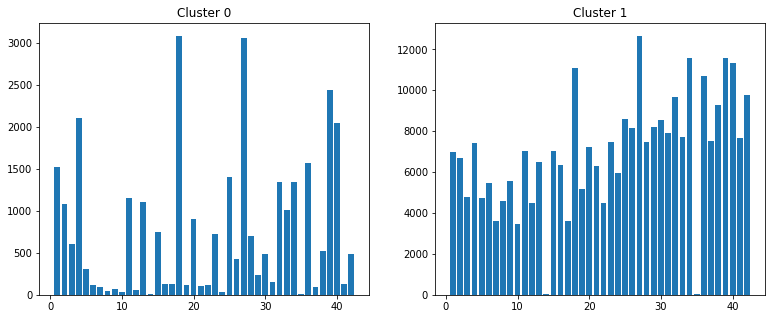

In [22]:
hist0=np.sum(cluster0, axis=0)
hist1=np.sum(cluster1, axis=0)
fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[0].bar(np.arange(1, len(hist0)+1),hist0)
ax[0].set_title('Cluster 0')
ax[1].bar(np.arange(1, len(hist1)+1),hist1)
ax[1].set_title('Cluster 1')

print('.')

So in general cluster zero has many more persons who either didn't choose an answer or were not show a question (given that missing elemnts were given a -1 value) 

We can then take a look at the maximum values in both clusters to further understand the difference between
the two groups

In [24]:
max0=np.where(max(hist0)==hist0)
min0=np.where(min(hist0)==hist0)

max1=np.where(max(hist1)==hist1)
min1=np.where(min(hist1)==hist1)

print('Max values in cluster 0')
print(cluster0.keys()[max0])

print('Max values in cluster 1')
print(cluster1.keys()[max1])


Max values in cluster 0
Index(['Q18_Python'], dtype='object')
Max values in cluster 1
Index(['Q16_Part_1_Python'], dtype='object')


In [25]:
print('Do you use python on a regular basis? -Cluster 0')
print(cluster0['Q16_Part_1_Python'].value_counts())

print('Do you use python on a regular basis? -Cluster 1')
print(cluster1['Q16_Part_1_Python'].value_counts())

print('Would you recomend Python to an  aspiring data scientist? -Cluster0')
print(cluster0['Q18_Python'].value_counts())

print('Would you recomend Python to an  aspiring data scientist? -Cluster1')
print(cluster1['Q18_Python'].value_counts())


Do you use python on a regular basis? -Cluster 0
0    6626
1    3058
Name: Q16_Part_1_Python, dtype: int64
Do you use python on a regular basis? -Cluster 1
1    12653
0     1522
Name: Q16_Part_1_Python, dtype: int64
Would you recomend Python to an  aspiring data scientist? -Cluster0
0    6597
1    3087
Name: Q18_Python, dtype: int64
Would you recomend Python to an  aspiring data scientist? -Cluster1
1    11094
0     3081
Name: Q18_Python, dtype: int64


So it seems that cluster 1 is composed mainly of people with a mostly good opinion about python as a programing language, while those in cluster 0 do not. Taking another look at the important features used in the SVM model classification of both clusters, we find that most of the important questions in differentiating both clusters have to do with types of data, how they area manipulated and interpreted and programing languages. In other words, ML related questions. We can  then use this knowledge to go back to the original data set and look at some of these questions for each cluster

In [126]:
#gets tsome relevant questions
q_keys=[mkeys[372],mkeys[355], mkeys[342], mkeys[263],mkeys[108],mkeys[124],mkeys[129], mkeys[128], 
        mkeys[86],mkeys[84],]
questions=multiplec.head()[q_keys].iloc[0,:]
data0=multi2.iloc[clus_index==0][q_keys]
data0 = data0.fillna(value=-1)

data1=multi2.iloc[clus_index==1][q_keys]
data1 = data1.fillna(value=-1)

Question labels are as follows:

In [114]:
print(questions)

Q48    Do you consider ML models to be "black boxes" ...
Q46    Approximately what percent of your data projec...
Q43    Approximately what percent of your data projec...
Q32    What is the type of data that you currently in...
Q20    Of the choices that you selected in the previo...
Q22    Of the choices that you selected in the previo...
Q26     Do you consider yourself to be a data scientist?
Q25    For how many years have you used machine learn...
Q18    What programming language would you recommend ...
Q17    What specific programming language do you use ...
Name: 0, dtype: object


We can then analyse the results quickly by counting

In [199]:
print('Opininons about data and programing languages- Cluster 0')
print('.')
i=0
for k in q_keys:
    col=data0[k]
    print(questions[i])
    print('_____ ', col.value_counts().keys()[0])
    print('_____ ',col.value_counts().keys()[1])
    print('.')
    i+=1

Opininons about data and programing languages- Cluster 0
.
Do you consider ML models to be "black boxes" with outputs that are difficult or impossible to explain?
_____  -1
_____  I do not know; I have no opinion on the matter
.
Approximately what percent of your data projects involve exploring model insights?
_____  -1
_____  0
.
Approximately what percent of your data projects involved exploring unfair bias in the dataset and/or algorithm?
_____  -1
_____  0
.
What is the type of data that you currently interact with most often at work or school? - Selected Choice
_____  -1
_____  Numerical Data
.
Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice
_____  -1
_____  Scikit-Learn
.
Of the choices that you selected in the previous question, which specific data visualization library or tool have you used the most? - Selected Choice
_____  -1
_____  Matplotlib
.
Do you consider yourself to be a data scientist?
_____  -1
___

In [198]:
print('Opininons about data and programing languages- Cluster 1')
print('.')
i=0
for k in q_keys:
    col=data1[k]
    print(questions[i])
    print('_____ ', col.value_counts().keys()[0])
    print('_____ ',col.value_counts().keys()[1])
    print('.')
    i+=1

Opininons about data and programing languages- Cluster 1
.
Do you consider ML models to be "black boxes" with outputs that are difficult or impossible to explain?
_____  I am confident that I can understand and explain the outputs of many but not all ML models
_____  I view ML models as "black boxes" but I am confident that experts are able to explain model outputs
.
Approximately what percent of your data projects involve exploring model insights?
_____  10-20
_____  0-10
.
Approximately what percent of your data projects involved exploring unfair bias in the dataset and/or algorithm?
_____  0
_____  0-10
.
What is the type of data that you currently interact with most often at work or school? - Selected Choice
_____  Numerical Data
_____  Tabular Data
.
Of the choices that you selected in the previous question, which ML library have you used the most? - Selected Choice
_____  Scikit-Learn
_____  -1
.
Of the choices that you selected in the previous question, which specific data visua

This results imply that the cluster 1 is composed of people with more
experience/ training that those in cluster 0. In addition, it would seem that, those in cluster 0 where not presented with a lot of quetions about types of data and programing languages (this is infered from the large number of -1 answers). It is worth noting that python is popular with experienced and inexperienced programers. Another interesting insight is that most people devote little time in interpreting their models, meaning that black box threatment of ML algorithms is very prominent in the medium.

It would be expected that a 3-means clustering would build on these results to further separate kagglers, who responded the 2018 ML survey
